# Profanity in Quora questions
This notebook investigates the use and distribution of profanity (offensive language) among the Quora dataset of questions. Perhaps detection of profaniity in a question could help determine whether the question is insincere. To flag inappropriate language, we use the list of words blacklisted by Google, found [here](https://www.freewebheaders.com/full-list-of-bad-words-banned-by-google/). Throughout the notebook, these are referred to as 'bad words'.

Please leave advice / comments below and feel free to fork.

Warning: This notebook displays language that may be offensive.


## Import packages and data

In [1]:
# Import packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Import training and test data from Quora questions dataset
train = pd.read_csv('/Volumes/SDMemory/Datasets/Quora/train.csv')
test = pd.read_csv('/Volumes/SDMemory/Datasets/Quora/test.csv')

# Import list of bad words (banned by Google)
bad_words = pd.read_csv('/Volumes/SDMemory/Datasets/Quora/bad_words.csv', header=None)

In [3]:
# Sample of bad words - some are actually not swear words as such
bad_words.sample(5)

,0
868,hard on
909,horniest
1636,violet wand
1140,nigger
874,hell


## Function to detect and store bad words from a given sentence

In [4]:
# Returns a list (possibly empty) of bad words in text
def detect_badwords(text):
    # tokenize the text
    tokens = word_tokenize(text)
    bad_found = []
    for word in tokens:
        for bad_word in bad_words[0]:
            if bad_word == word:
                bad_found.append(word)
    return bad_found

In [5]:
# Simple examples
s1 = 'This politician speaks nothing but bullshit, what a twat'
s2 = 'The sun shines brightly today'
[detect_badwords(s) for s in [s1,s2]]

[['bullshit', 'twat'], []]

## Apply function to the Quora dataset


In [6]:
# # Register `pandas.progress_apply' with `tqdm`
# tqdm.pandas()
# # Run detect_badwords over all entries in the training data
# temp_size = 10000
# train_bad_words = train['question_text'].progress_apply(detect_badwords)
# # Add as a column to the DataFrame
# train['bad_words'] = train_bad_words

# # Export the new dataframe as a pickle file for import at a later date
# train.to_pickle('/Volumes/SDMemory/Datasets/Quora/train_bw.pkl')

In [7]:
# Import training data with bad words detected
train = pd.read_pickle('/Volumes/SDMemory/Datasets/Quora/train_bw.pkl')

In [8]:
# Collect all entries that contain bad words
bools_bw_nonempty = [train['bad_words'].iloc[i] != [] for i in tqdm(range(train.shape[0]))]
df_bw = train[bools_bw_nonempty]

# Sincere set
df_bw_sincere = df_bw[df_bw['target'] == 0]
# Insincere set
df_bw_insincere = df_bw[df_bw['target'] ==1 ]


HBox(children=(IntProgress(value=0, max=1306122), HTML(value='')))

### Sample of sincere posts containing bad words

In [9]:
df_bw_sincere.sample(5)

,qid,question_text,target,bad_words
1157247,e2c0a0219494afdf70e2,Are there any Indian porn production companies?,0,[porn]
363108,472bcb1729c627e4e63b,"I am 17 and my cock has started bending, is it...",0,[cock]
1213178,edc724b65a58b60e84fb,What do you feel during sex?,0,[sex]
707816,8a96fd9f33747694aa24,Is it true that only Muslims go to heaven and ...,0,[hell]
1175948,e673080efce93b596500,How do I crack Civil Service exam?,0,[crack]


### Sample of insincere posts containing bad words

In [10]:
df_bw_insincere.sample(5)

,qid,question_text,target,bad_words
841342,a4e581cbc24778e44dd2,"Why do we need licenses for guns, operating mo...",1,[jackass]
576528,70f66d7326f05354b11c,Why is Modi a very bad politician? I have said...,1,[dirty]
83882,106babe0141c5213c715,Do you like to have sex with your mother?,1,[sex]
901341,b09b2090d659cb0ab059,How many more Republican senators and represen...,1,[sexual]
1025107,c8e1ac32f6615203d7c5,Am I transphobic if I don't think anyone with ...,1,[penis]


## Count of posts with bad words

In [11]:
# Total number of entries that use at least one bad word
bw_total_sincere = len(df_bw_sincere)
bw_total_insincere = len(df_bw_insincere)

print('Total number of sincere posts that contain at least one bad word:', bw_total_sincere)
print('Total number of insincere posts that contain at least one bad word:', bw_total_insincere)


Total number of sincere posts that contain at least one bad word: 34363
Total number of insincere posts that contain at least one bad word: 14529


In [12]:
# Total number of sincere and insincere posts
num_sincere = len(train[ train['target'] == 0])
num_insincere = len(train[ train['target'] == 1])

In [13]:
# Proportions
bw_ratio_sincere = bw_total_sincere/num_sincere
bw_ratio_insincere = bw_total_insincere/num_insincere

# Plot
ratio_data = pd.DataFrame(
    {'Flag': ['Sincere', 'Insincere'],
     'Proportion': [bw_ratio_sincere, bw_ratio_insincere]}
)
ratio_data

,Flag,Proportion
0,Sincere,0.028044
1,Insincere,0.179792


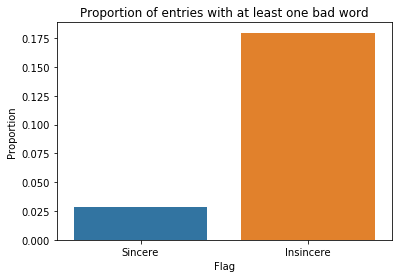

In [14]:
# Plot of proportion of questions that contain bad words
sns.barplot(x='Flag', 
            y='Proportion',
            data=ratio_data).set_title('Proportion of entries with at least one bad word');

In [15]:
print('''From the training data, insincere posts are about
{:.1f} times more likely to contain bad words'''.format(bw_ratio_insincere/bw_ratio_sincere))

From the training data, insincere posts are about
6.4 times more likely to contain bad words


There are many sincere posts that also contain bad words. Perhaps most of these words in the sincere posts are not so bad. Maybe we can extract the particularly vulgar words.

## Distribution among the bad words

In [16]:
# Define a function to flatten a list of lists
def flatten(l):
    x = []
    for sublist in l:
        for element in sublist:
            x.append(element)
    return x

# import collections library which has functions to compute frequency of elements
import collections

In [17]:
# Function to take in a DataFrame of Quora entries and output a DataFrame of swear words and frequency count
def count_frequency(df):
    # put all the used bad words into a list
    bw_list = flatten(df['bad_words'].tolist())
    # count the frequency of each bad word
    counter = collections.Counter(bw_list)
    # re-order in terms of frequency
    counter = counter.most_common()
    # put into a DataFrame
    df_out = pd.DataFrame(counter, columns = ['Word', 'Frequency'])
    # output
    return df_out


### Count frequency of swear words in sincere and insincere questions

In [18]:
freq_sincere = count_frequency(df_bw_sincere)
freq_insincere = count_frequency(df_bw_insincere)

In [19]:
freq_sincere.head()

,Word,Frequency
0,sex,6376
1,kill,2335
2,sexual,1685
3,gay,1518
4,crack,1367


In [20]:
# Add a column for frequency normalised by the total number of questions in the set
num_sincere = len(train[ train['target'] == 0])
num_insincere = len(train[ train['target'] == 1])
print('Number of sincere questions:', num_sincere)
print('Number of insincere questions:', num_insincere)

freq_sincere['Normalised Frequency'] = freq_sincere['Frequency']/num_sincere
freq_insincere['Normalised Frequency'] = freq_insincere['Frequency']/num_insincere

Number of sincere questions: 1225312
Number of insincere questions: 80810


In [21]:
freq_insincere.head()

,Word,Frequency,Normalised Frequency
0,sex,2530,0.031308
1,gay,1425,0.017634
2,stupid,987,0.012214
3,kill,913,0.011298
4,fuck,748,0.009256


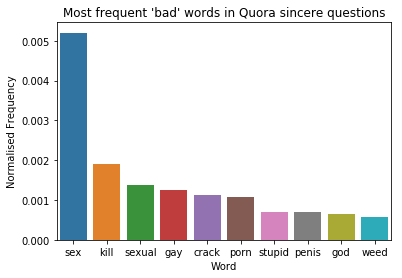

In [22]:
# Bar plot: 10 most frequent bad words in sincere questions
sns.barplot(x='Word',
            y='Normalised Frequency',
            data=freq_sincere.iloc[:10]
           ).set_title('Most frequent \'bad\' words in Quora sincere questions');

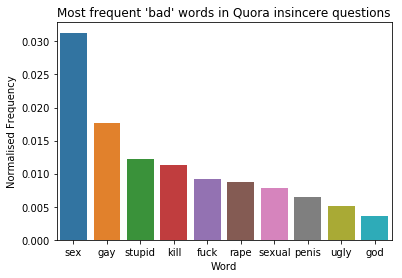

In [23]:
# Bar plot: 10 most frequent bad words in insincere questions
sns.barplot(x='Word',
            y='Normalised Frequency',
            data=freq_insincere.iloc[:10]
           ).set_title('Most frequent \'bad\' words in Quora insincere questions');

### Scatter plot of bad words against their relative frequency in the Quora posts

In [24]:
# Create DataFrame with bad-word frequencies in sincere and insincere sets
temp = freq_insincere.set_index('Word')['Normalised Frequency'].rename('Frequency in insincere posts')
temp2 = freq_sincere.set_index('Word')['Normalised Frequency'].rename('Frequency in sincere posts')
df_scat = pd.concat([temp,temp2], axis=1).fillna(0)
df_scat.head()

,Frequency in insincere posts,Frequency in sincere posts
Doublelift,0.000000,8.161187e-07
Sandler,0.000025,5.712831e-06
a55,0.000012,0.000000e+00
anal,0.000928,1.738333e-04
anilingus,0.000000,8.161187e-07


In [25]:
np.arange(1,10,1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

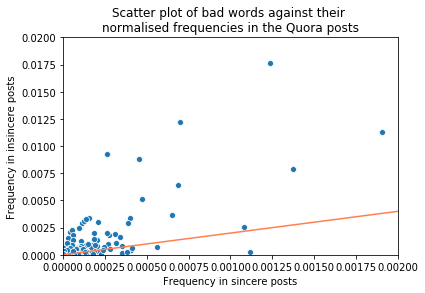

In [26]:
# Scatter plot and line y=x
ax = sns.scatterplot(x='Frequency in sincere posts', 
                y='Frequency in insincere posts', 
                data=df_scat)
ax.set_xlim(left=0, right=0.002)
ax.set_ylim(bottom=0, top=0.02)
ax.set_title('''Scatter plot of bad words against their 
normalised frequencies in the Quora posts''');
sns.lineplot(np.linspace(0,0.002,100), 2*np.linspace(0,0.002,100),
            color='coral')

## Removal of certain bad words from the list

Let's try removing words from the 'bad words' list, that lie below the orange line (y=x) in the scatter plot above i.e. any bad word that occurs more often in the sincere set than the insincere set

In [27]:
# Extract words below the orange line
bools = df_scat['Frequency in insincere posts'] < df_scat['Frequency in sincere posts']
bw_remove = df_scat[bools].index.values.tolist()
# Sample of these words
len(bw_remove)

146

In [33]:
# Remove any instances in train of bad words in bw_remove
train_dropbw = train
for i in tqdm(range(len(train))):
    entry = train_dropbw['bad_words'].iloc[i]
    if entry != []:    
        entry = [x for x in entry if x not in bw_remove]
        train_dropbw['bad_words'].iloc[i] = entry        
                

HBox(children=(IntProgress(value=0, max=1306122), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
# Export as a pic